In [1]:
import math
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import pandas as pd
import random
from scipy import stats  #t-test
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp1d
from scipy import signal

import xlrd
from itertools import groupby

from statistics import mean
from matplotlib import cm
import csv

from scipy.spatial.distance import cdist

C:\Users\ljr\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
pathfp=r'F:\KyotoUdata\EEG\FP'
filesfp=sorted(os.listdir(pathfp))
pathsf=r'F:\KyotoUdata\EEG\SF'
filessf=sorted(os.listdir(pathsf))
pathre=r'F:\KyotoUdata\EEG\RE'
filesre=sorted(os.listdir(pathre))
pathst=r'F:\KyotoUdata\EEG\ST'
filesst=sorted(os.listdir(pathst))

In [3]:
print(filesfp)

['006_MS9EEG1FP.csv', '007_MS9EEG1FP.csv', '008_MS9EEG1FP.csv', '010_MS9EEG1FP.csv', '011_MS9EEG1FP.csv', '014_MS9EEG1FP.csv', '015_MS9EEG1FP.csv', '018_MS9EEG1FP.csv', '024_MS9EEG1FP.csv', '025_MS9EEG1FP.csv', '026_MS9EEG1FP.csv', '030_MS9EEG1FP.csv', '032_MS9EEG1FP.csv', '033_MS9EEG1FP.csv', '034_MS9EEG1FP.csv', '035_MS9EEG1FP.csv', '037_MS9EEG1FP.csv', '038_MS9EEG1FP.csv', '041_MS9EEG1FP.csv', '042_MS9EEG1FP.csv']


In [4]:
datafpm=np.empty((len(filesfp),1),dtype=object)
datasfm=np.empty((len(filessf),1),dtype=object)
datarem=np.empty((len(filesre),1),dtype=object)
datastm=np.empty((len(filesst),1),dtype=object)

In [5]:
datafpc=np.empty((len(filesfp),1),dtype=object)
datasfc=np.empty((len(filessf),1),dtype=object)
datarec=np.empty((len(filesre),1),dtype=object)
datastc=np.empty((len(filesst),1),dtype=object)

In [6]:
headfpm=np.empty((len(filesfp),16),dtype=object)
headsfm=np.empty((len(filessf),16),dtype=object)
headrem=np.empty((len(filesre),16),dtype=object)
headstm=np.empty((len(filesst),16),dtype=object)

In [7]:
headfpc=np.empty((len(filesfp),16),dtype=object)
headsfc=np.empty((len(filessf),16),dtype=object)
headrec=np.empty((len(filesre),16),dtype=object)
headstc=np.empty((len(filesst),16),dtype=object)

In [8]:
def removespace(listin):
    for i in listin:
        if '' in listin:
            listin.remove('')
    return listin

In [9]:
def dataread(pathin):
    datap= pd.read_csv(pathin)
    columnlen=len(datap.iloc[:,0])
    head=[]
    with open (pathin) as f:
        test = list(csv.reader(f, delimiter=" "))
        test1=[x for x in test[:][0] if x!='']
        rowlen=len(test1)
    data=np.zeros((rowlen-1,columnlen))
    with open (pathin) as f:
        test = list(csv.reader(f, delimiter=" "))
        for i in range(columnlen):
            tem=[x for x in test[:][i] if x!='']
            data[:,i]=tem[1:]
            head.append(tem[0])
    return head,data

In [10]:
for i in range(len(filesfp)):
    headfp,datafp=dataread(pathfp+'\\'+filesfp[i])
    headsf,datasf=dataread(pathsf+'\\'+filessf[i])
    headre,datare=dataread(pathre+'\\'+filesre[i])
    headst,datast=dataread(pathst+'\\'+filesst[i])
    #print(headfp[:16],headfp[18:-1])
    headfpc[i]=headfp[:16]
    headfpm[i]=headfp[18:-1]
    headsfc[i]=headsf[:16]
    headsfm[i]=headsf[18:-1]
    headrec[i]=headre[:16]
    headrem[i]=headre[18:-1]
    headstc[i]=headst[:16]
    headstm[i]=headst[18:-1]
    
    datafpc[i]=[datafp[:,:16]]
    datafpm[i]=[datafp[:,18:-1]]
    datasfc[i]=[datasf[:,:16]]
    datasfm[i]=[datasf[:,18:-1]]
    datarec[i]=[datare[:,:16]]
    datarem[i]=[datare[:,18:-1]]
    datastc[i]=[datast[:,:16]]
    datastm[i]=[datast[:,18:-1]]

In [11]:
headfpc[1]

array(['Fz_1', 'F3_1', 'FC5_1', 'FC1_1', 'C3_1', 'CP1_1', 'Pz_1', 'P3_1',
       'P7_1', 'P4_1', 'P8_1', 'CP2_1', 'C4_1', 'FC6_1', 'FC2_1', 'F4_1'],
      dtype=object)

In [12]:
len(datafpc[0][0])/500

120.314

In [13]:
sampling_rate = 500
downsample_factor = 1  # In this case, downsample by 1 second

In [14]:
ddatafpm=np.empty((len(filesfp),1),dtype=object)
ddatasfm=np.empty((len(filessf),1),dtype=object)
ddatarem=np.empty((len(filesre),1),dtype=object)
ddatastm=np.empty((len(filesst),1),dtype=object)

ddatafpc=np.empty((len(filesfp),1),dtype=object)
ddatasfc=np.empty((len(filessf),1),dtype=object)
ddatarec=np.empty((len(filesre),1),dtype=object)
ddatastc=np.empty((len(filesst),1),dtype=object)

In [15]:
def downsample_time_serieso(time_series, sampling_rate, downsample_factor):
    # Calculate the number of samples to average for downsampling
    samples_per_second = sampling_rate
    samples_to_average = int(samples_per_second * downsample_factor)

    # Calculate overlap
    overlap = samples_to_average // 2

    # Calculate the number of windows
    num_windows = (len(time_series) - samples_to_average) // overlap + 1

    # Initialize the downsampled time series array
    downsampled_time_series = np.zeros((num_windows, 16))

    # Populate the downsampled time series array using overlapping windows
    for i in range(num_windows):
        start = i * overlap
        end = start + samples_to_average
        window_data = time_series[start:end, :]# Extract the windowed data
        #print('w',len(window_data))
        downsampled_time_series[i] = np.mean(window_data, axis=0)  # Compute the mean along the window
        #print('d',downsampled_time_series[i])
    return downsampled_time_series

In [16]:
def downsample_time_seriesonover(time_series, sampling_rate, downsample_factor):#no overlap
    # Calculate the number of samples to average for downsampling
    samples_per_second = sampling_rate
    samples_to_average = int(samples_per_second * downsample_factor)

    # Calculate overlap
    overlap = samples_to_average // 2

    # Calculate the number of windows
    num_windows = (len(time_series) - samples_to_average) // overlap + 1

    # Initialize the downsampled time series array
    downsampled_time_series = np.zeros((num_windows, 16))

    # Populate the downsampled time series array using overlapping windows
    for i in range(num_windows):
        start = i * overlap
        end = start + overlap
        window_data = time_series[start:end, :]# Extract the windowed data
        #print('w',len(window_data))
        downsampled_time_series[i] = np.mean(window_data, axis=0)  # Compute the mean along the window
        #print('d',downsampled_time_series[i])
    return downsampled_time_series

In [17]:
def downall(dataallin,dataout):
    for i in range(len(filesfp)):
        datain=dataallin[i][0]
        downin=downsample_time_serieso(datain, sampling_rate, downsample_factor)
        dataout[i]=[downin]
    return dataout

In [18]:
def downallnover(dataallin,dataout):#no overlap
    for i in range(len(filesfp)):
        datain=dataallin[i][0]
        downin=downsample_time_seriesonover(datain, sampling_rate, downsample_factor)
        dataout[i]=[downin]
    return dataout

In [19]:
ddatafpm=downallnover(datafpm,ddatafpm)
ddatafpc=downallnover(datafpc,ddatafpc)

ddatasfm=downallnover(datasfm,ddatasfm)
ddatasfc=downallnover(datasfc,ddatasfc)

ddatarem=downallnover(datarem,ddatarem)
ddatarec=downallnover(datarec,ddatarec)

ddatastm=downallnover(datastm,ddatastm)
ddatastc=downallnover(datastc,ddatastc)

In [20]:
bdatam=np.empty((len(filesfp),1),dtype=object)
bdatac=np.empty((len(filesfp),1),dtype=object)

In [21]:
def datacombine(datafpin,datasfin,datarein,datastin,datacin):
    for i in range(len(datafpin)):
        datacin[i]=[np.r_[datafpin[i][0],datasfin[i][0],datarein[i][0],datastin[i][0]]]
    return datacin

In [22]:
bdatam=datacombine(ddatafpm,ddatasfm,ddatarem,ddatastm,bdatam)
bdatac=datacombine(ddatafpc,ddatasfc,ddatarec,ddatastc,bdatac)

In [23]:
headfpc[0][0]

'Fz_1'

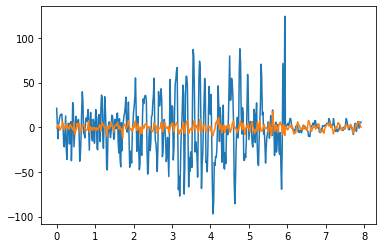

In [24]:
xlabel=np.arange(len(bdatam[0][0][:,1]))/60
#plt.plot(xlabel,bdatam[0][0][:,1])
plt.plot(xlabel,bdatam[-2][0][:,8])
plt.plot(xlabel,bdatam[-2][0][:,10])
#plt.xlim(2,3)

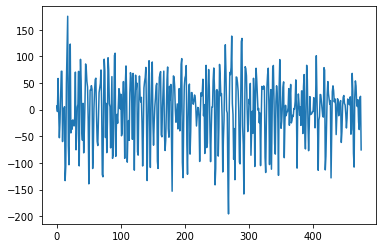

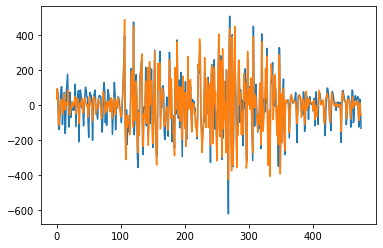

In [25]:
plt.plot(bdatam[0][0][:,8]-bdatam[0][0][:,10])
plt.show()
plt.plot(bdatam[0][0][:,8])
plt.plot(bdatam[0][0][:,10])
plt.show()

In [26]:
print(bdatam[0][0][0,8]-bdatam[0][0][0,10],bdatam[0][0][0,8],bdatac[0][0][0,8])

6.8247659999999755 40.63978799999999 -2.182366000000003


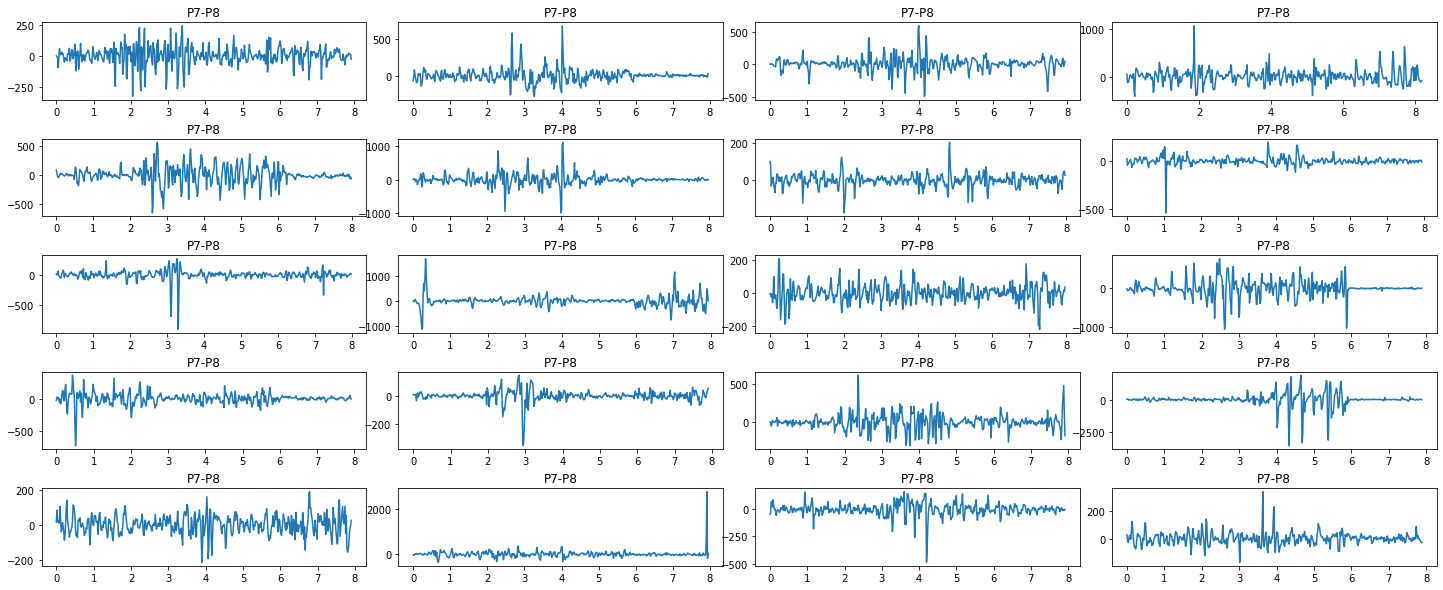

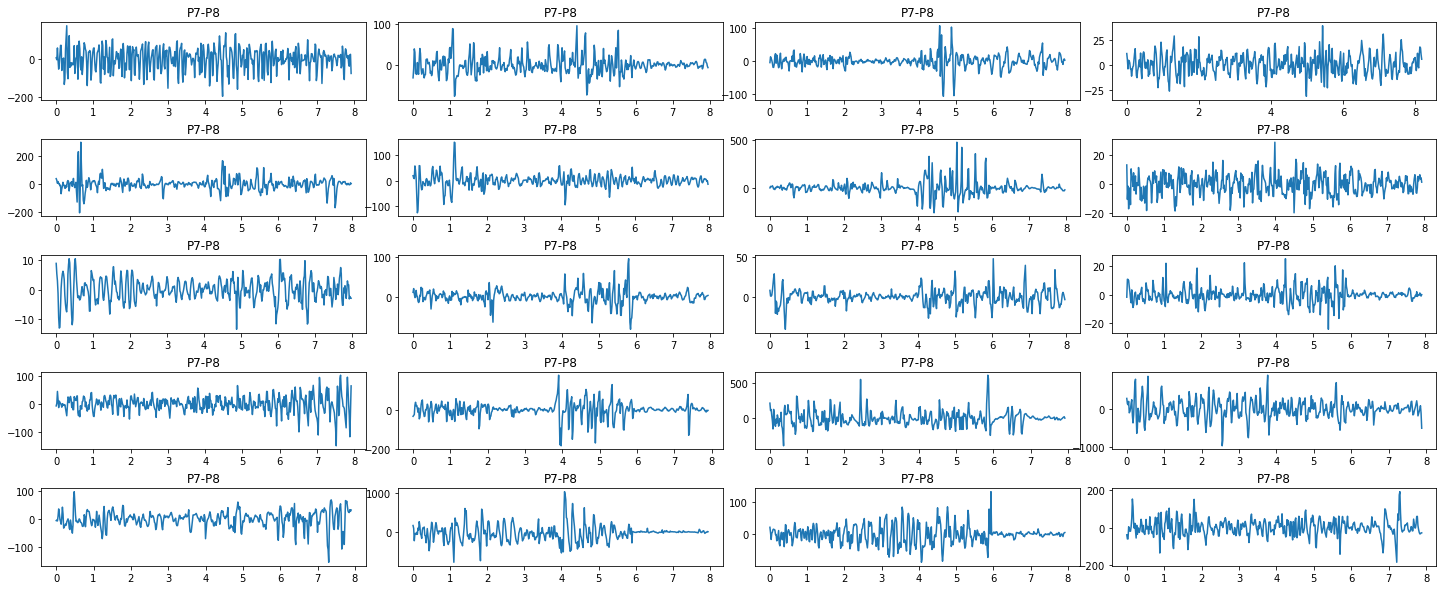

In [28]:
fig=plt.figure(figsize=(25,10))
num_rows = len(bdatac)//4+(len(bdatac)%4>0)
for i in range(len(bdatac)):
    plt.subplot(num_rows,4,i+1)
    xlabel=np.arange(len(bdatac[i][0][:,1]))/60
    plt.plot(xlabel,bdatac[i][0][:,8]-bdatac[i][0][:,10])
    #plt.plot(xlabel,bdatam[i][0][:,13])
    #plt.show()
    plt.subplots_adjust(wspace=0.1,hspace=0.5)
    plt.title('P7-P8')

    #namesave=r'E:\KyotoUdata\EEG\rawlrc'+'\\'+'P7_P8'
    #fig.savefig(namesave,bbox_inches='tight', pad_inches=0,dpi=300)

fig=plt.figure(figsize=(25,10))
num_rows = len(bdatam)//4+(len(bdatam)%4>0)
for i in range(len(bdatam)):
    plt.subplot(num_rows,4,i+1)
    xlabel=np.arange(len(bdatam[i][0][:,1]))/60
    plt.plot(xlabel,bdatam[i][0][:,8]-bdatam[i][0][:,10])
    #plt.plot(xlabel,bdatam[i][0][:,13])
    #plt.show()
    plt.subplots_adjust(wspace=0.1,hspace=0.5)
    plt.title('P7-P8')
    #namesave=r'E:\KyotoUdata\EEG\rawlrm'+'\\'+'P7_P8'
    #fig.savefig(namesave,bbox_inches='tight', pad_inches=0,dpi=300)

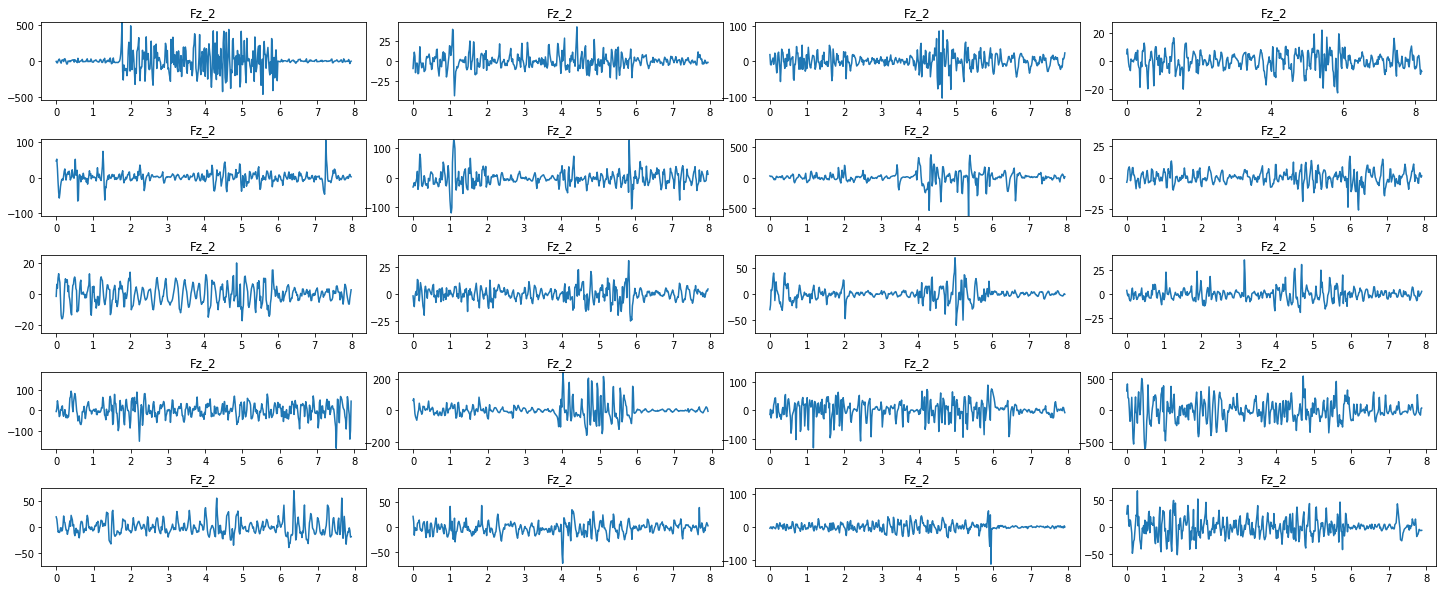

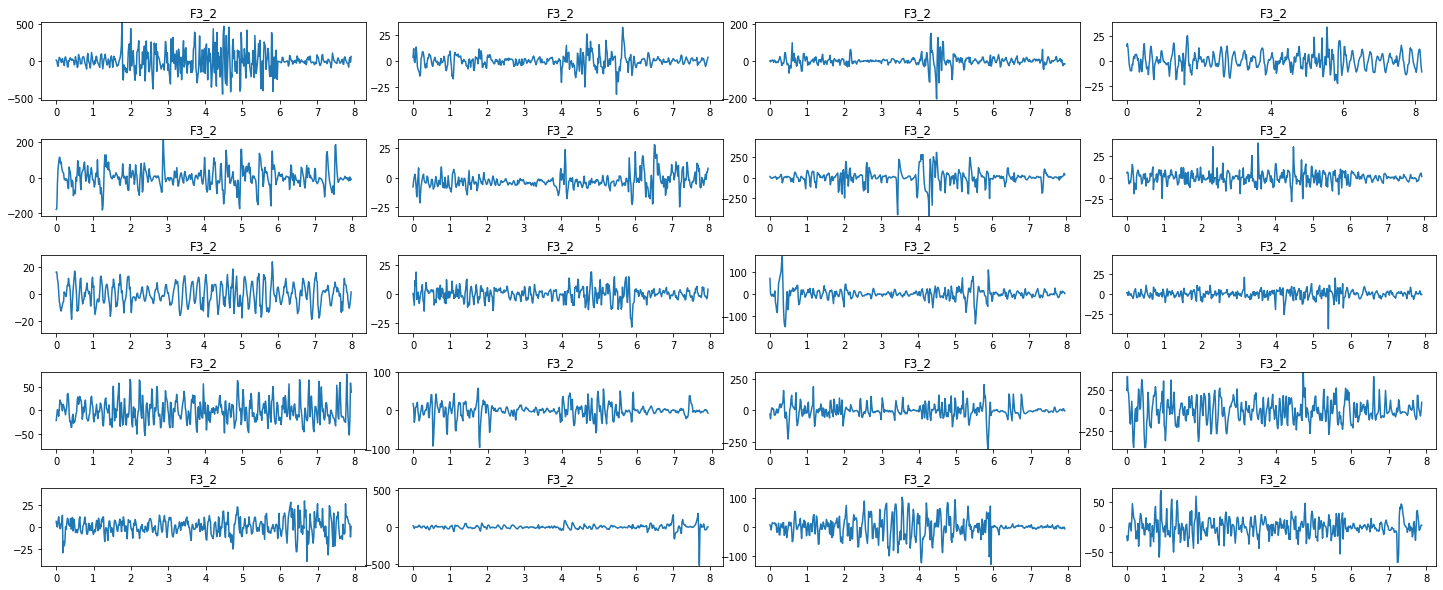

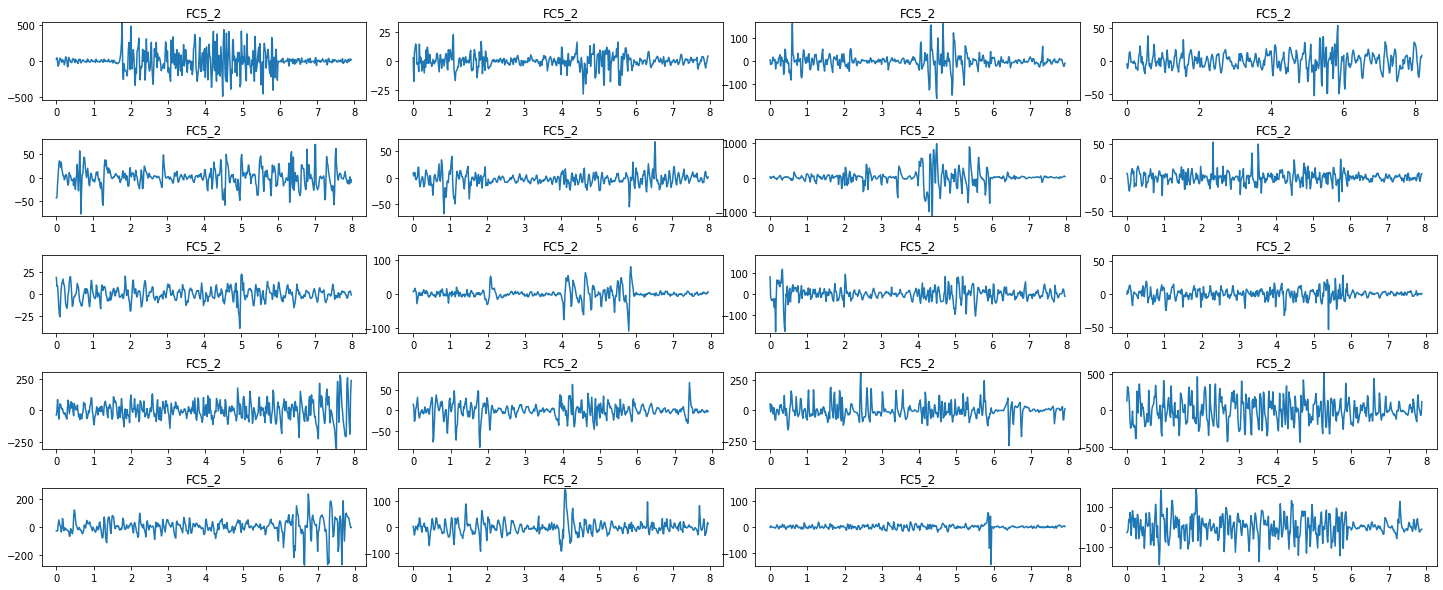

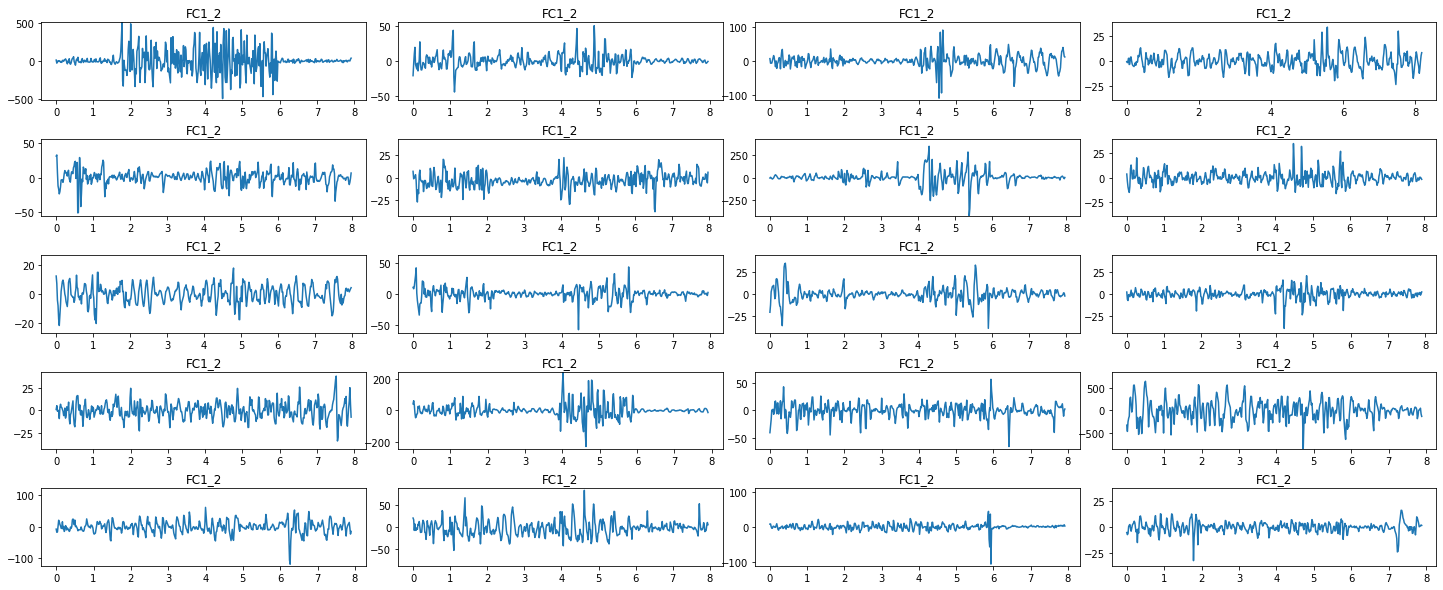

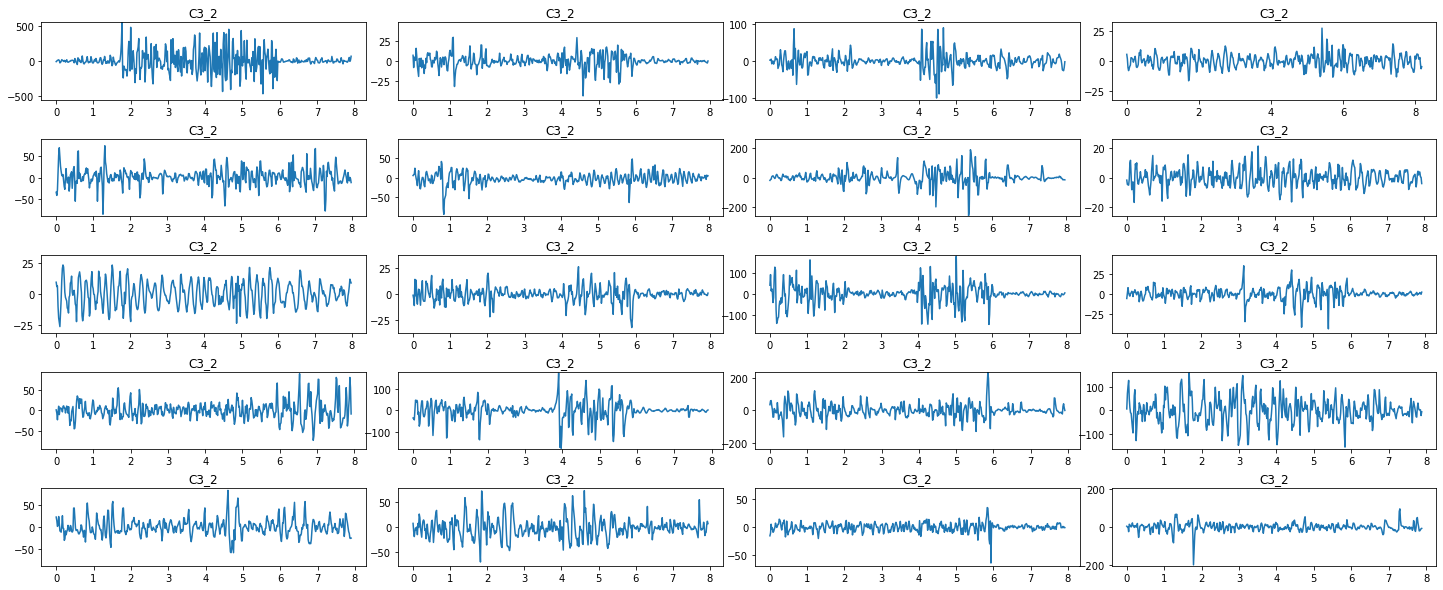

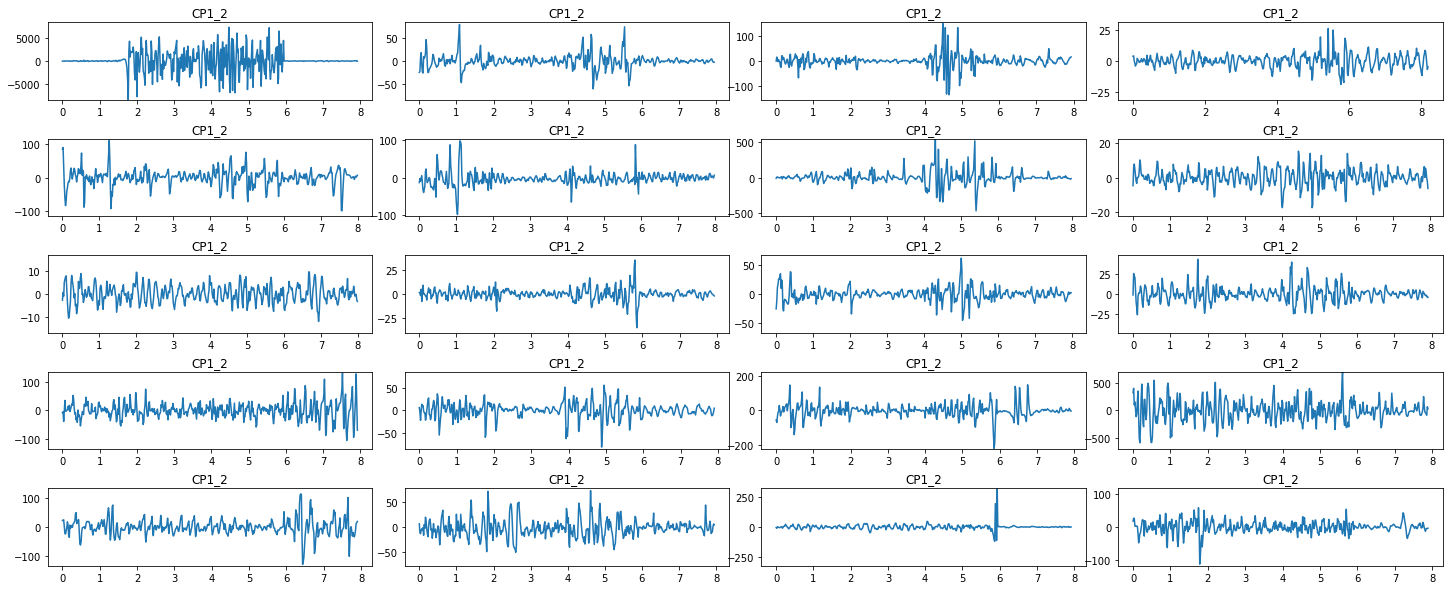

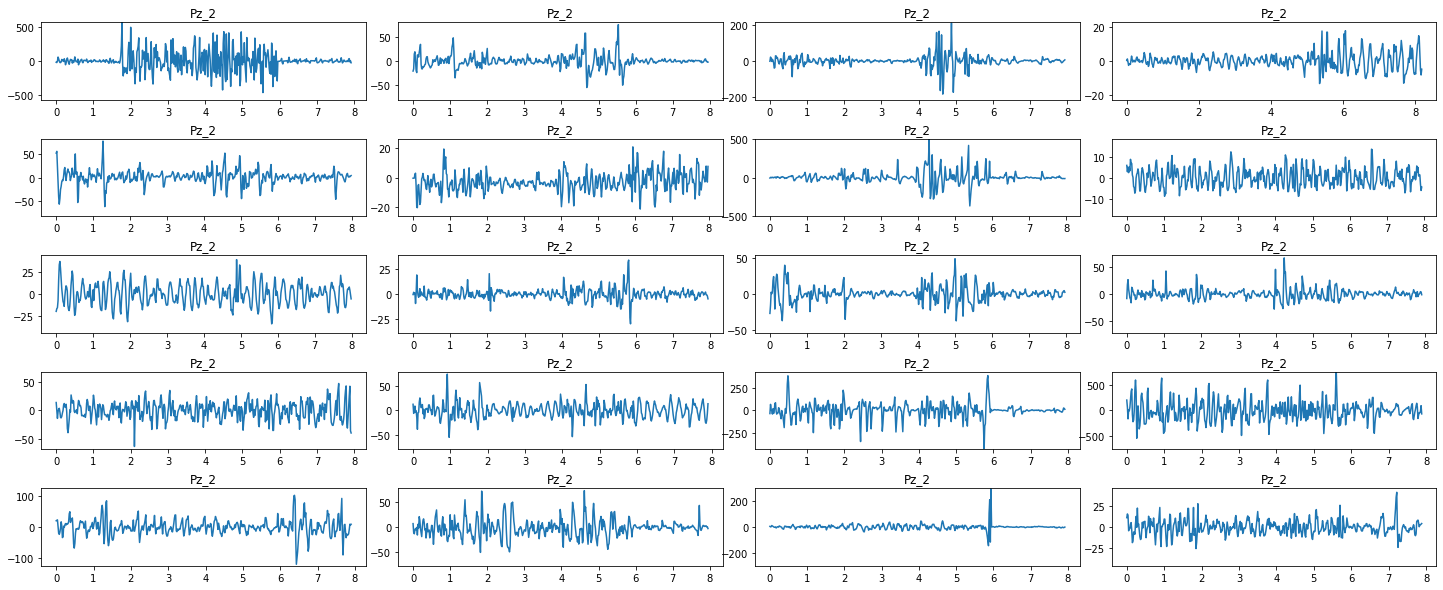

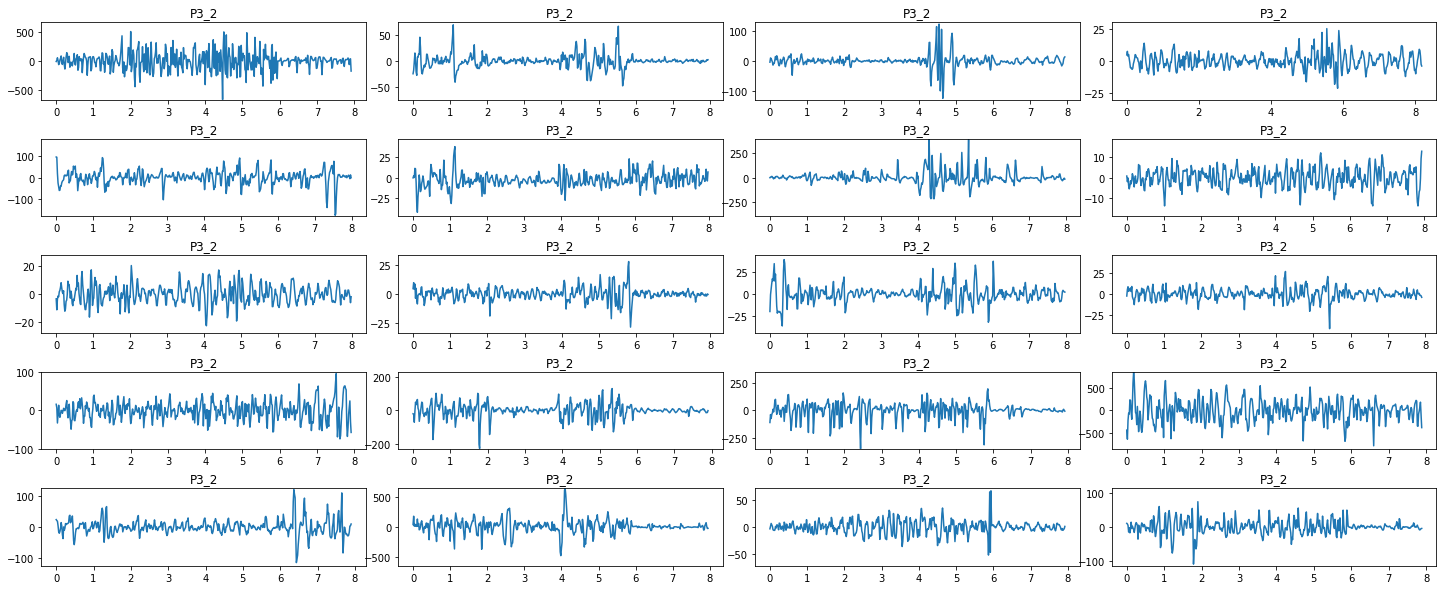

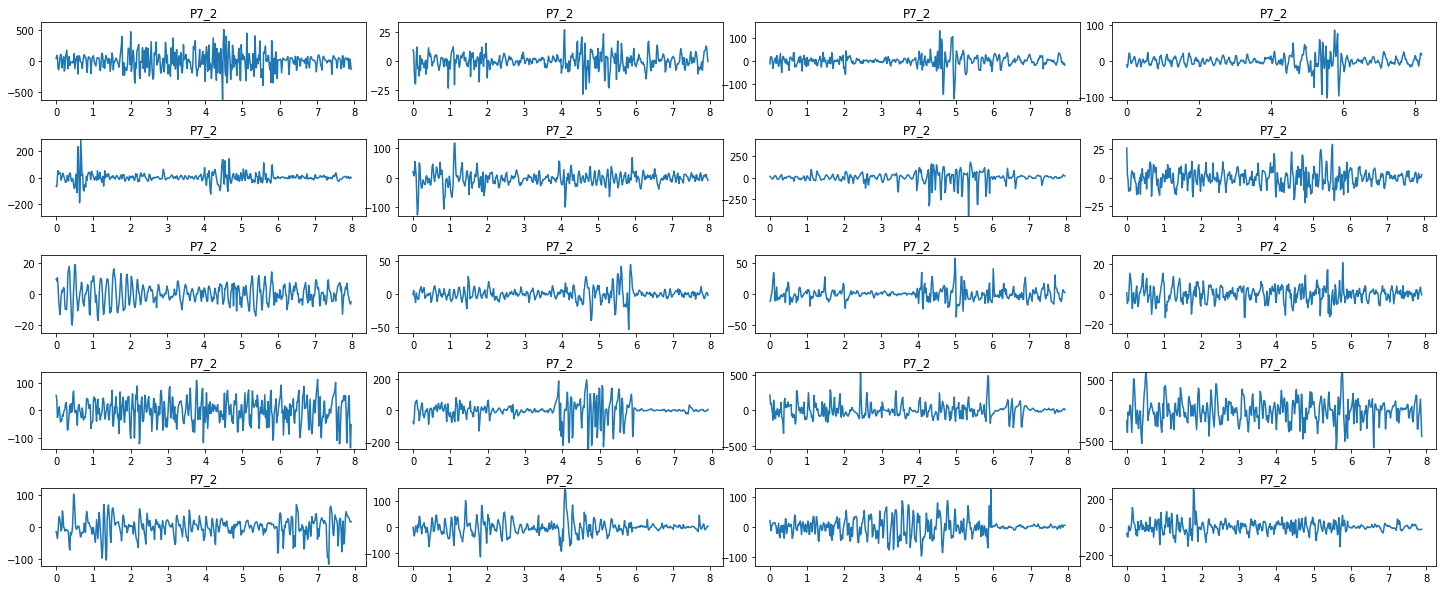

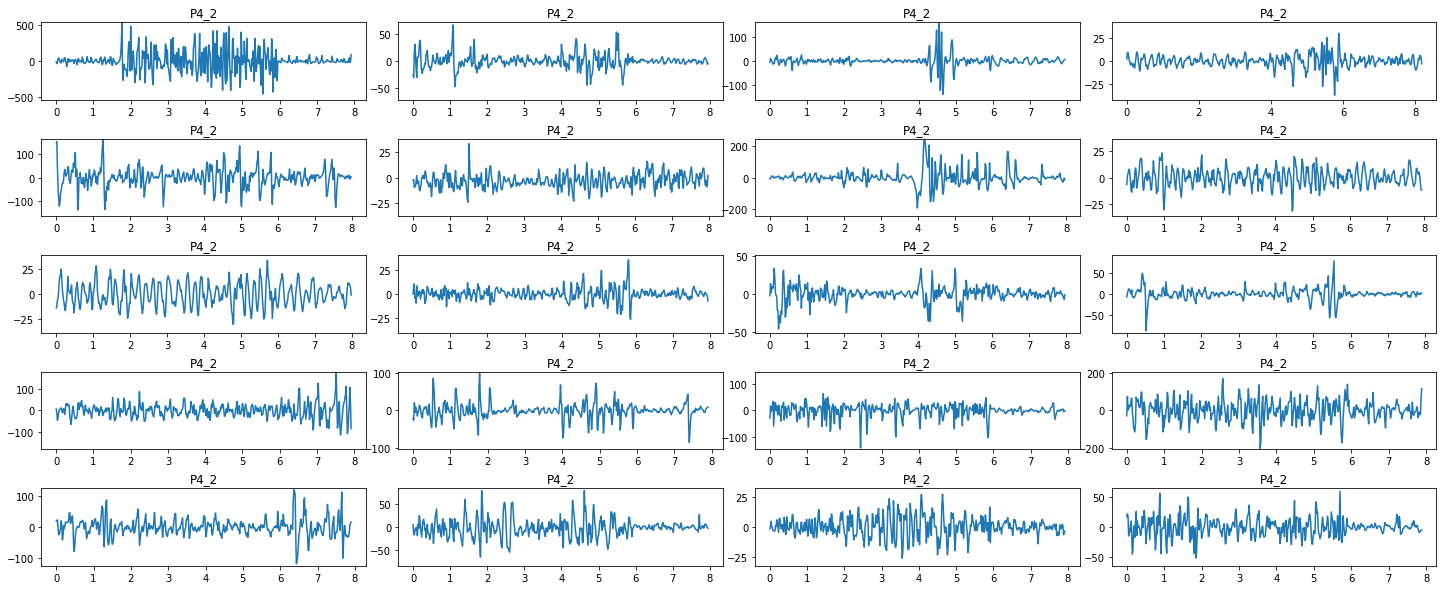

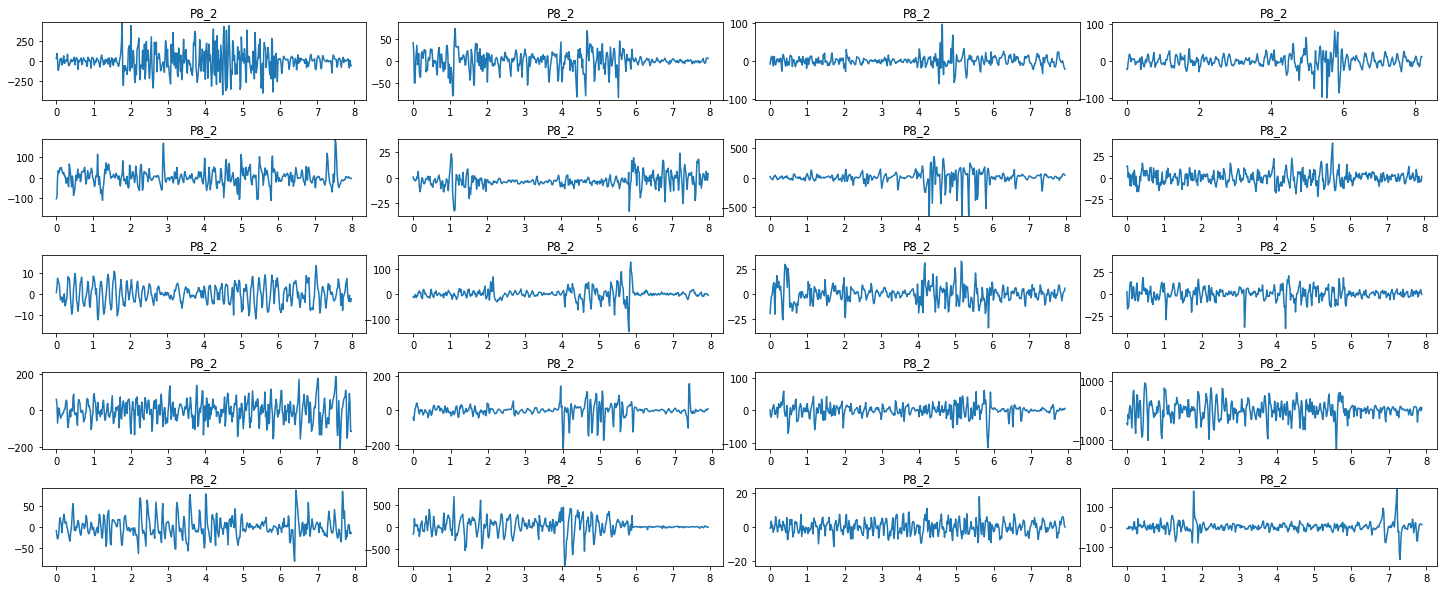

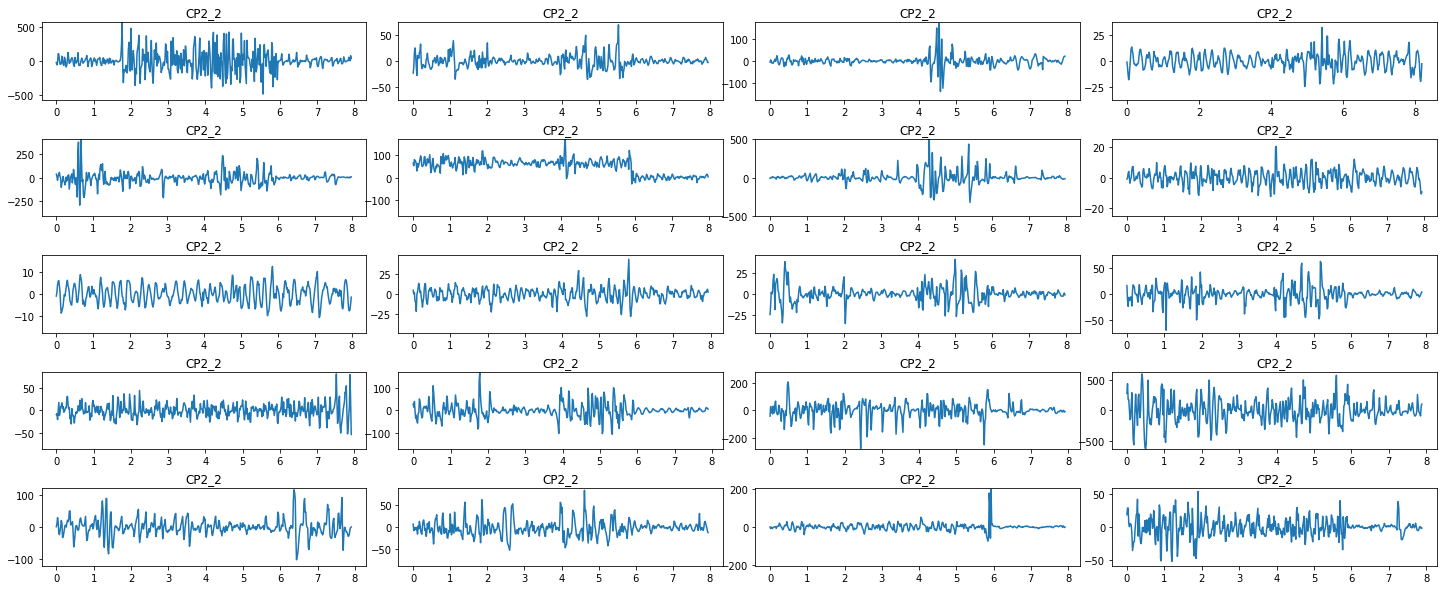

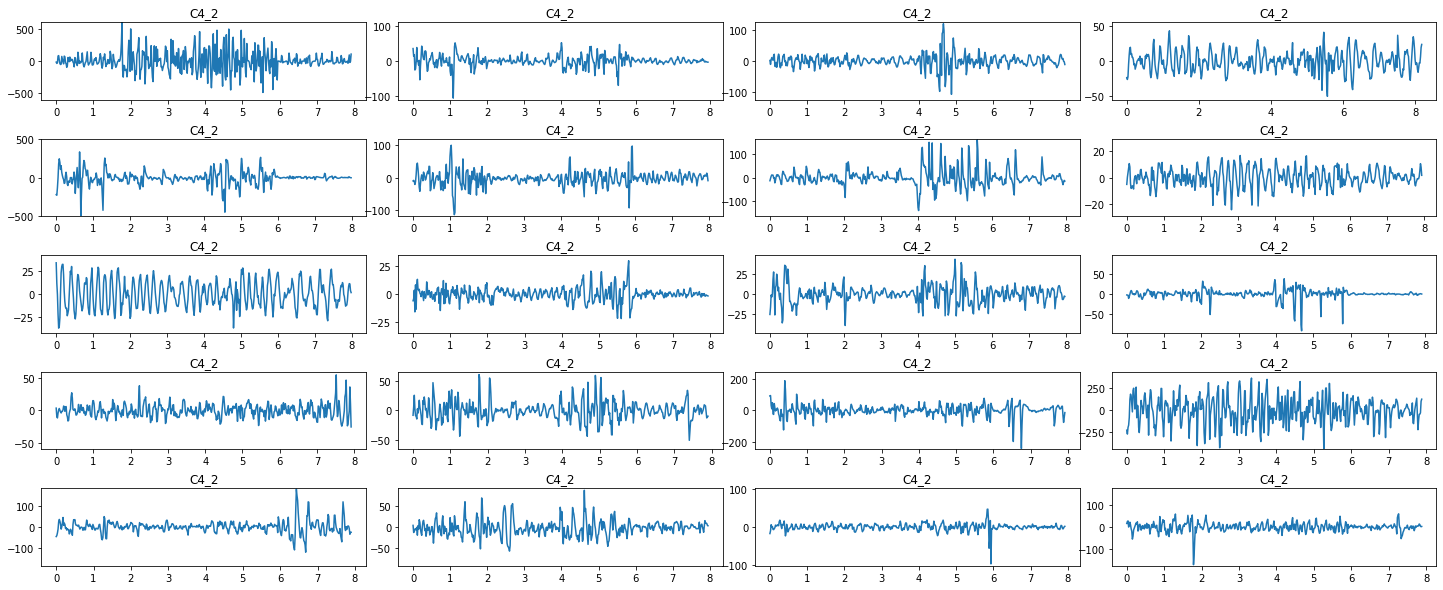

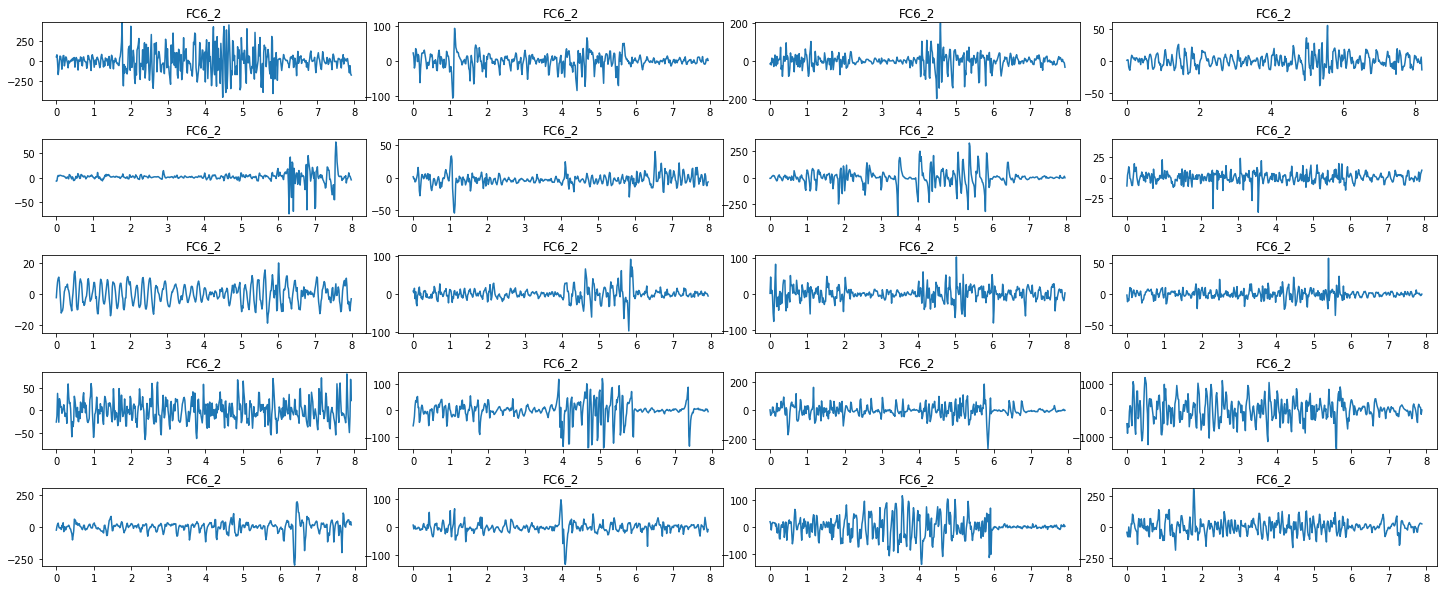

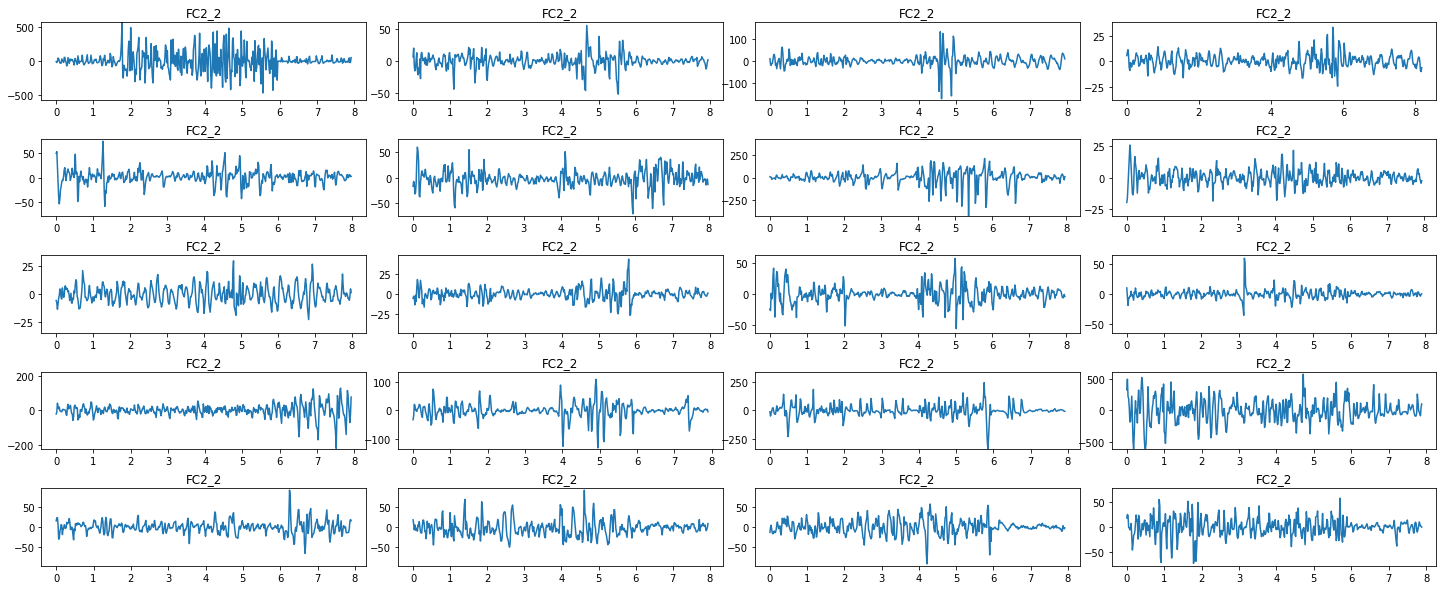

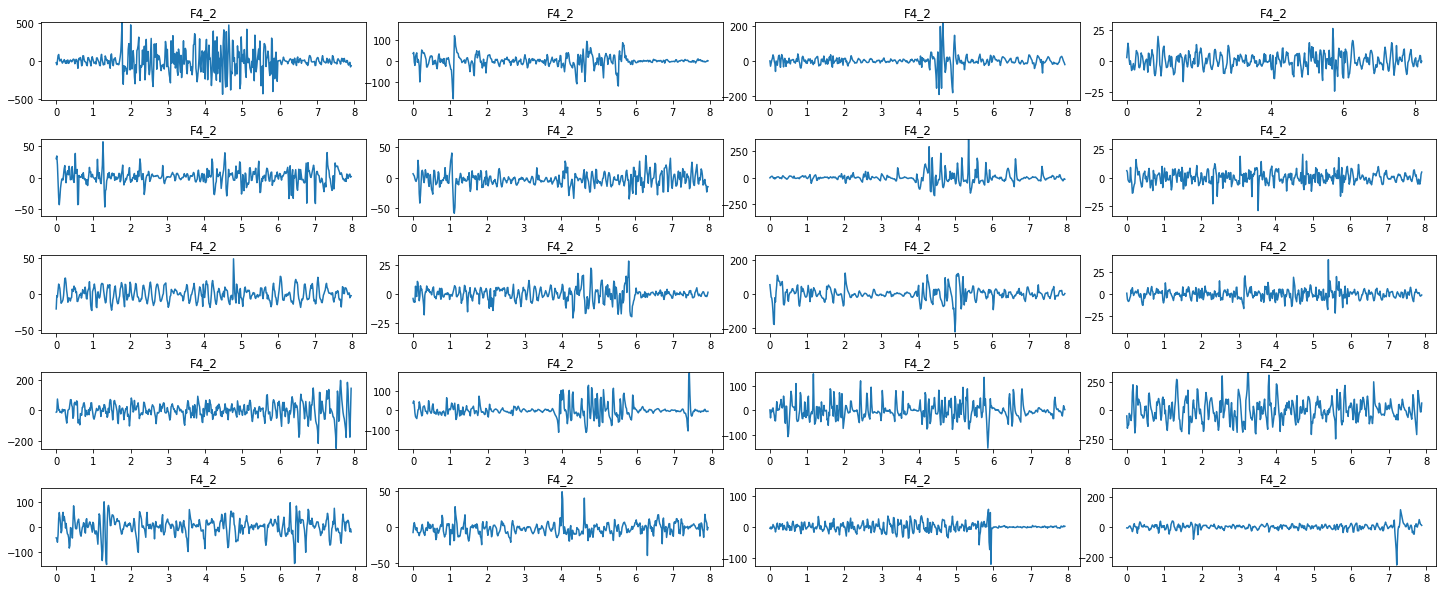

In [29]:
for j in range(len(bdatam[0][0][0])):
    fig=plt.figure(figsize=(25,10))
    num_rows = len(bdatam)//4+(len(bdatam)%4>0)
    for i in range(len(bdatam)):
        plt.subplot(num_rows,4,i+1)
        xlabel=np.arange(len(bdatam[i][0][:,j]))/60
        plt.plot(xlabel,bdatam[i][0][:,j])
        if np.abs(np.min(bdatam[i][0][:,j]))>=np.max(bdatam[i][0][:,j]):
            plt.ylim(np.min(bdatam[i][0][:,j])-5,np.abs(np.min(bdatam[i][0][:,j]))+5)
        else:
            plt.ylim(-np.max(bdatam[i][0][:,j])-5,np.max(bdatam[i][0][:,j])+5)
        plt.title(headfpm[0][j])
    plt.subplots_adjust(wspace=0.1,hspace=0.5)
    plt.show()
    #namesave=r'E:\KyotoUdata\EEG\rawm'+'\\'+headfpm[0][j]
    #fig.savefig(namesave,bbox_inches='tight', pad_inches=0,dpi=300)

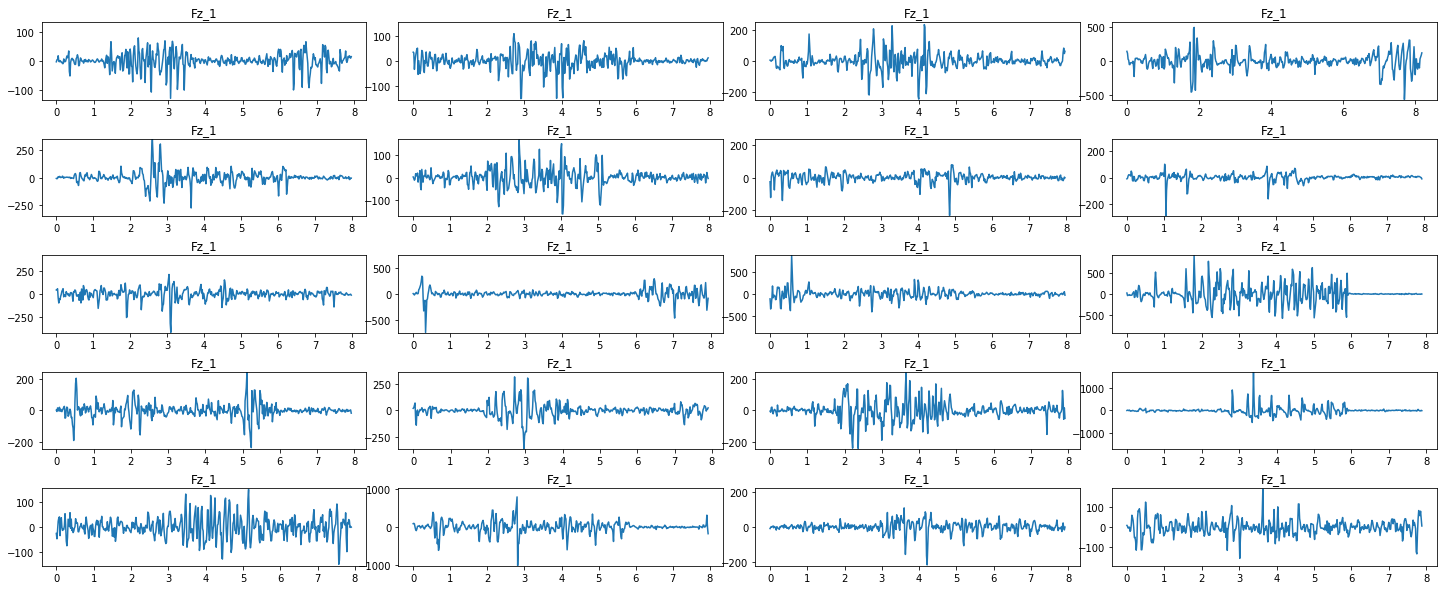

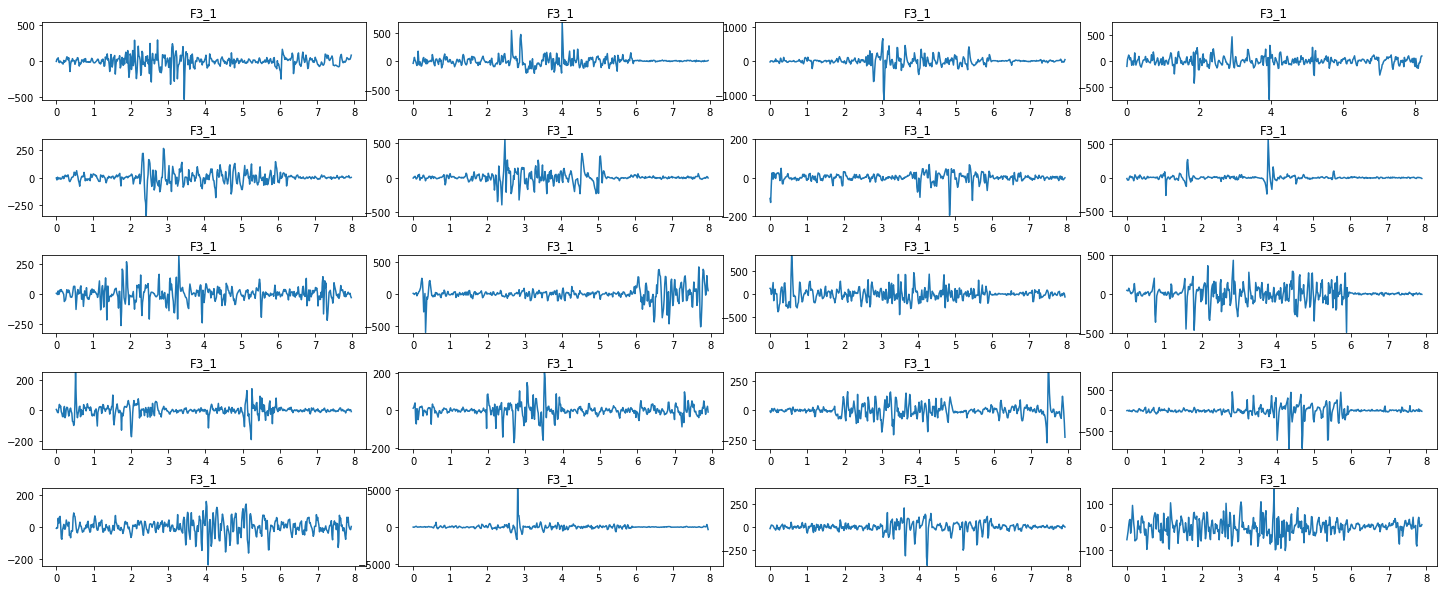

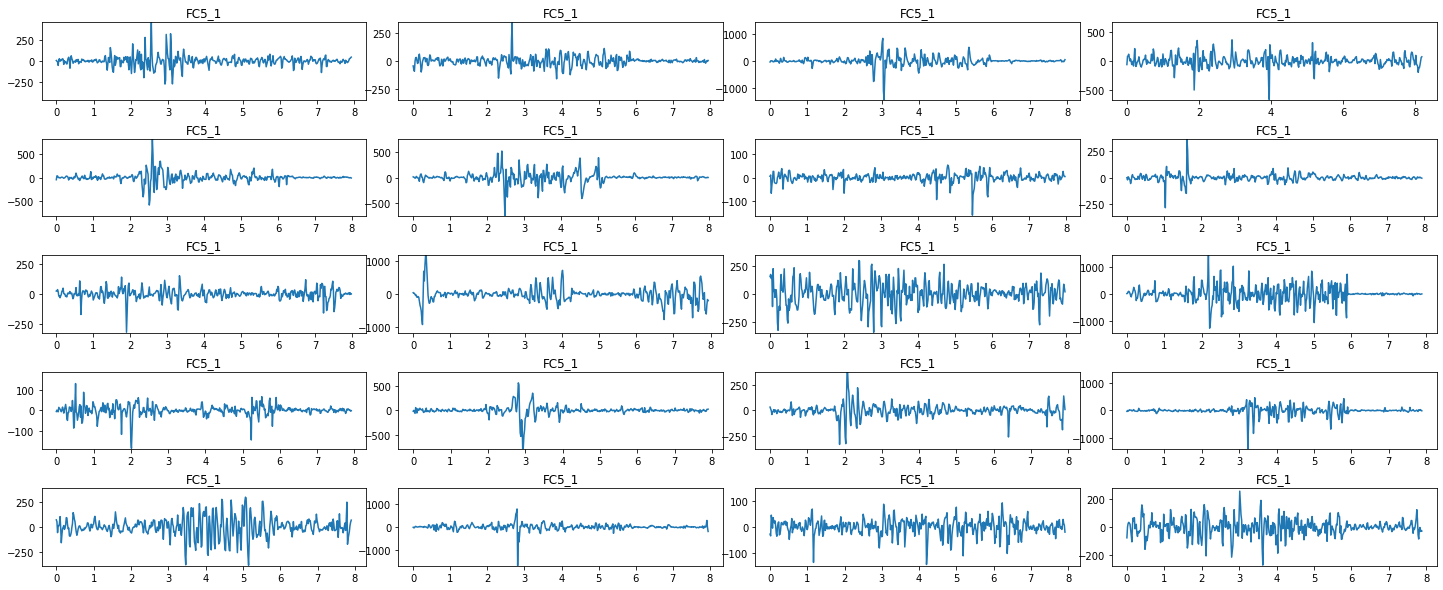

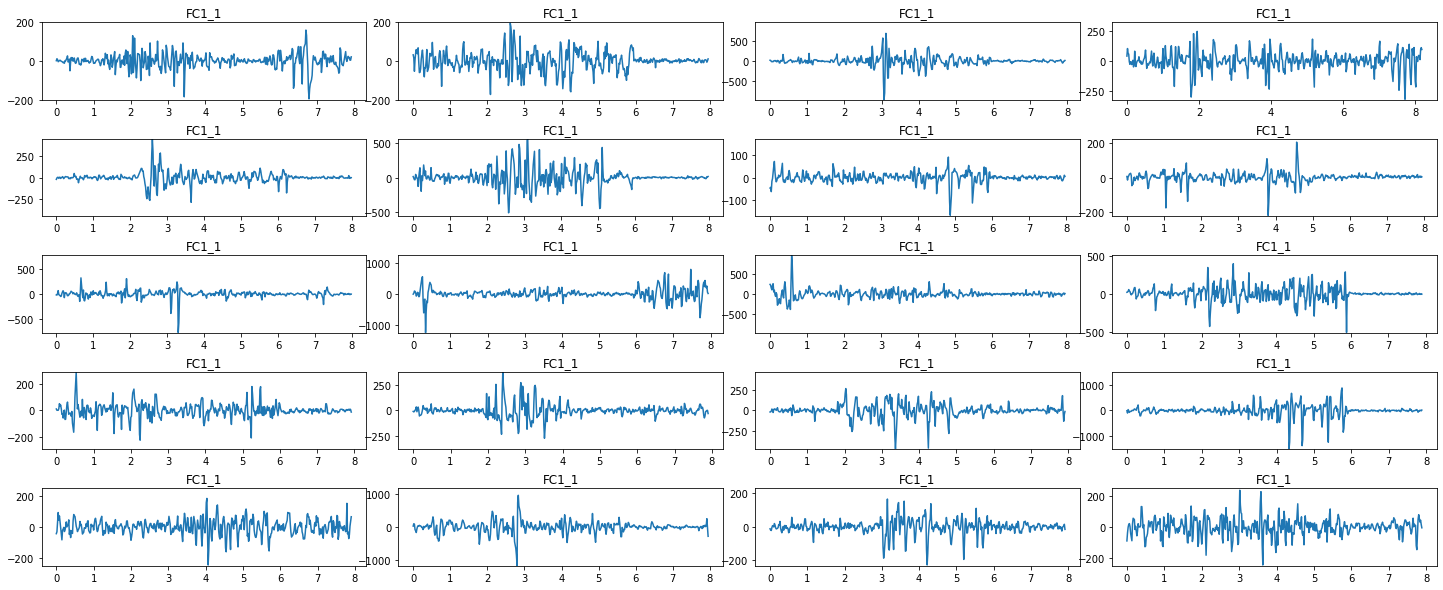

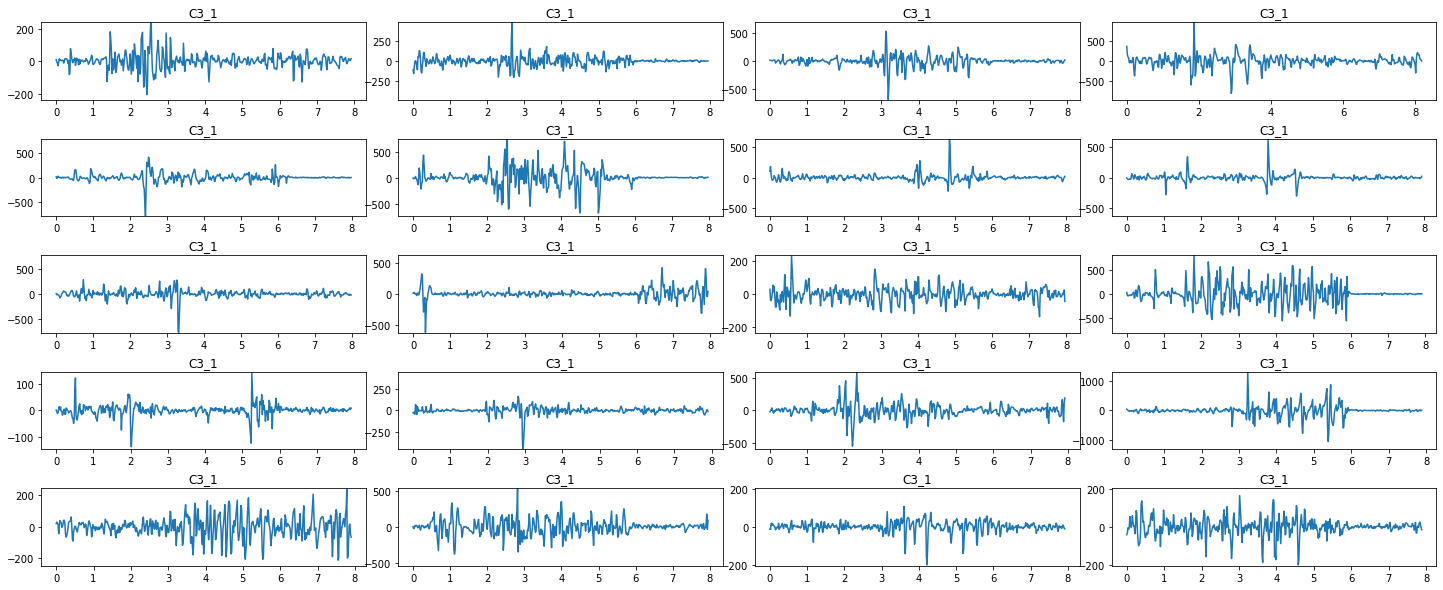

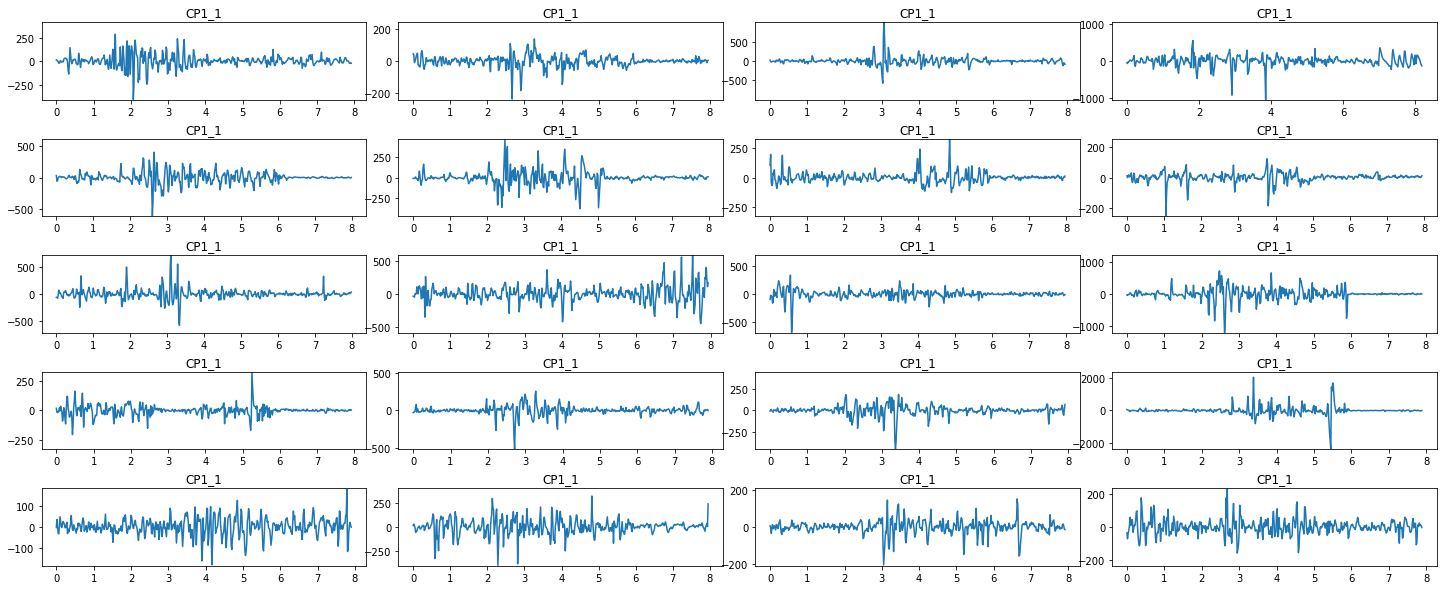

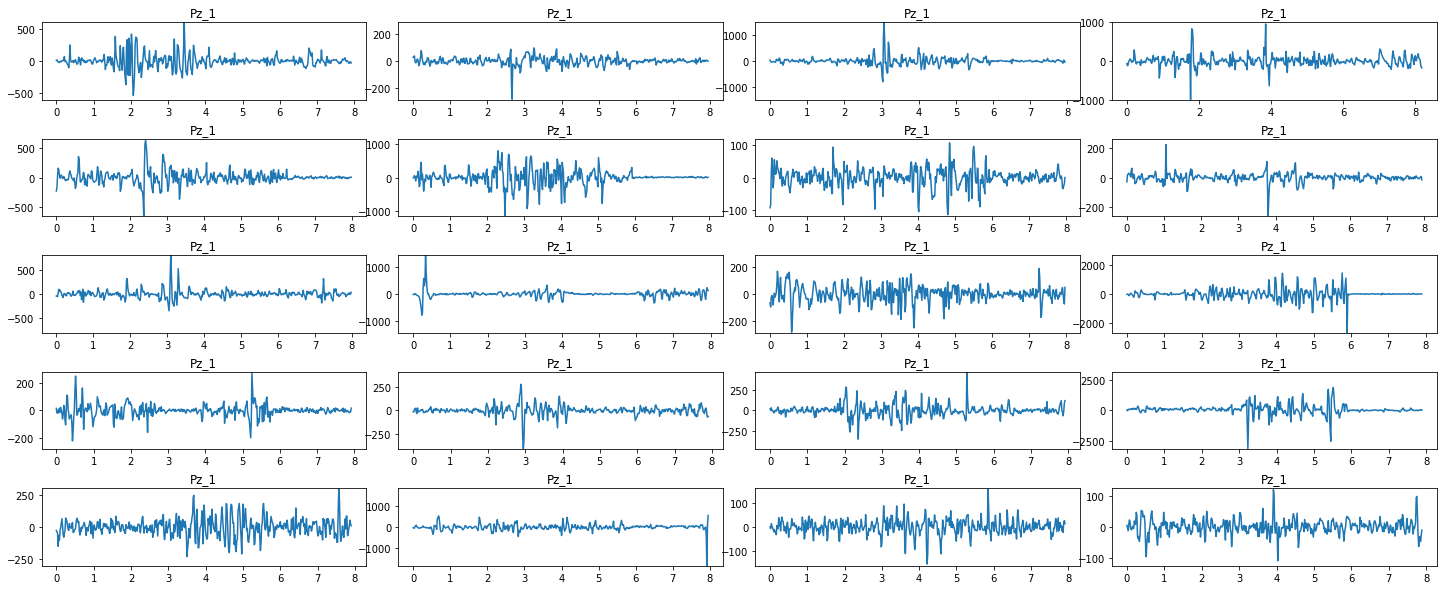

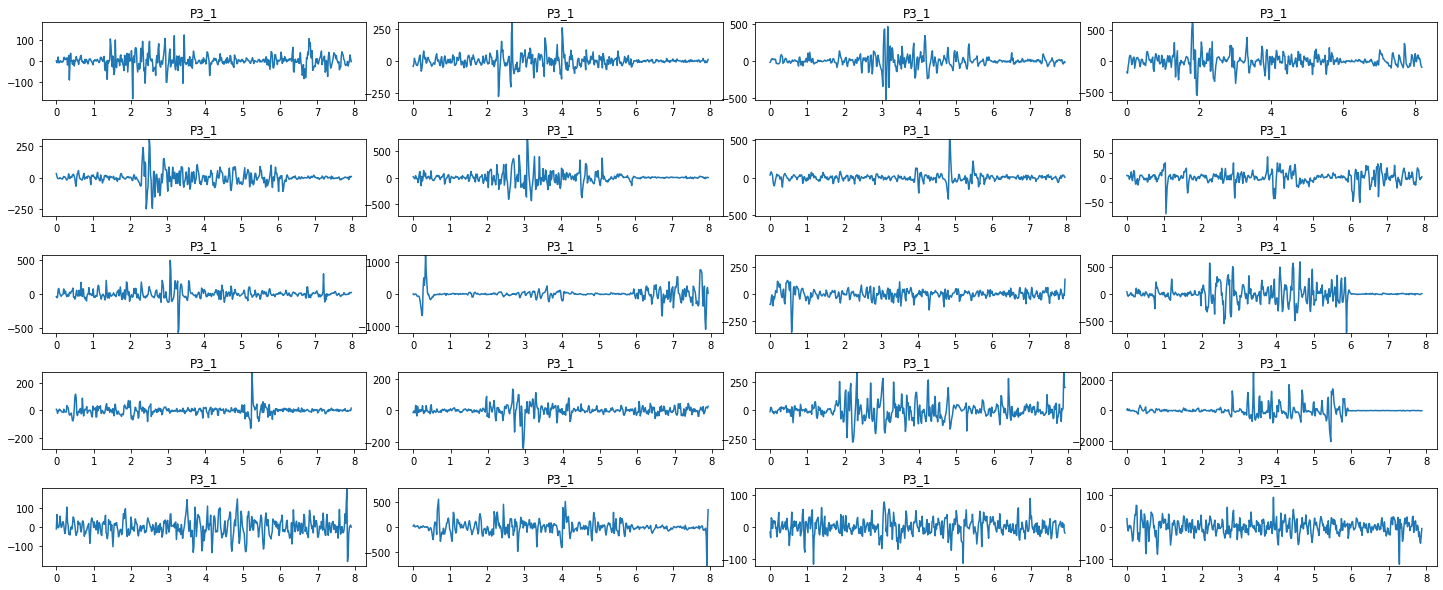

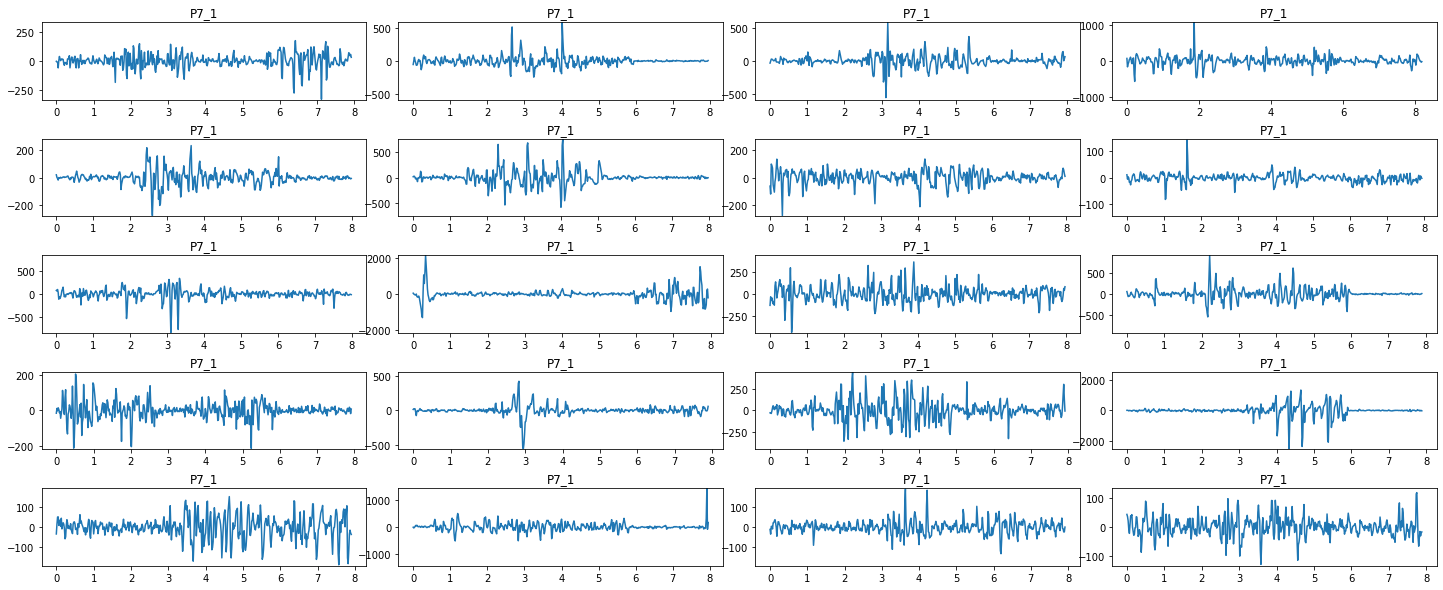

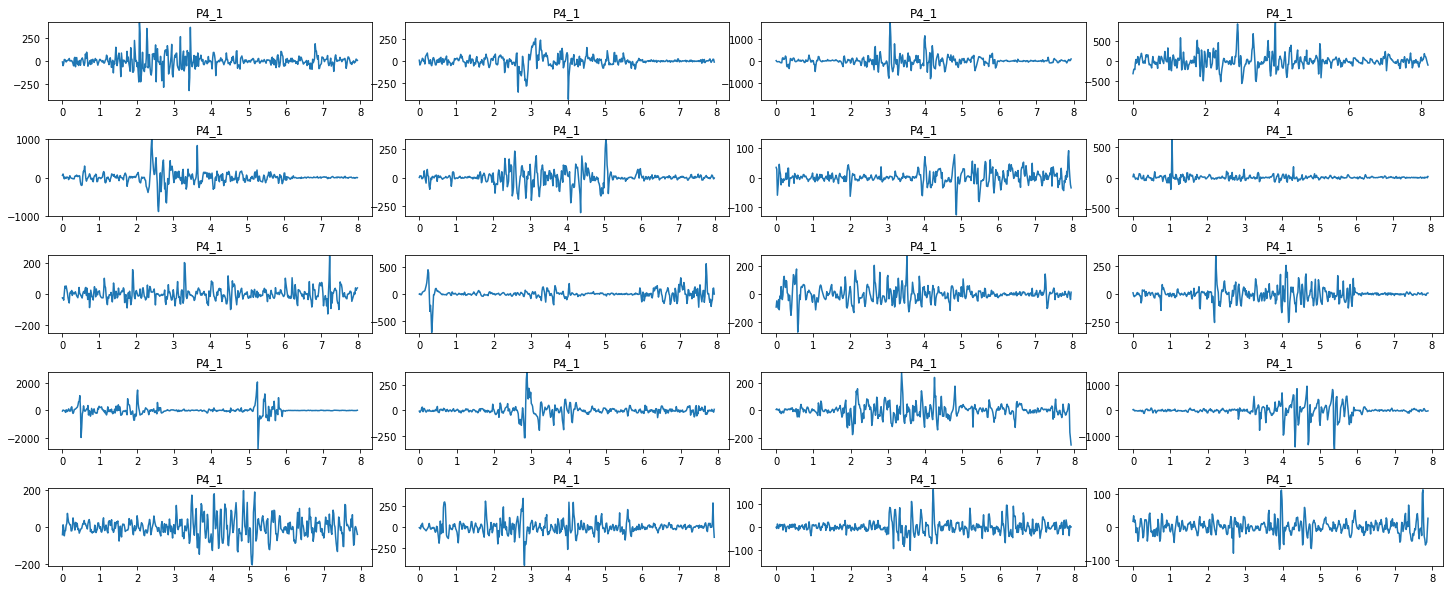

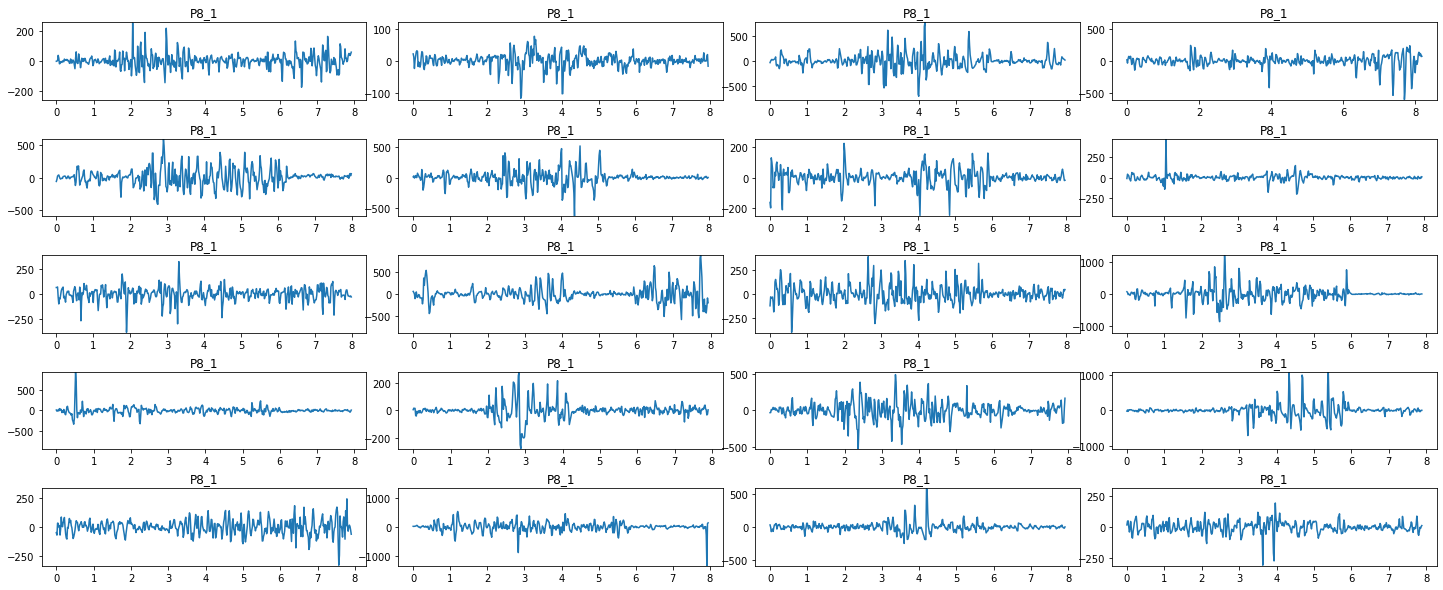

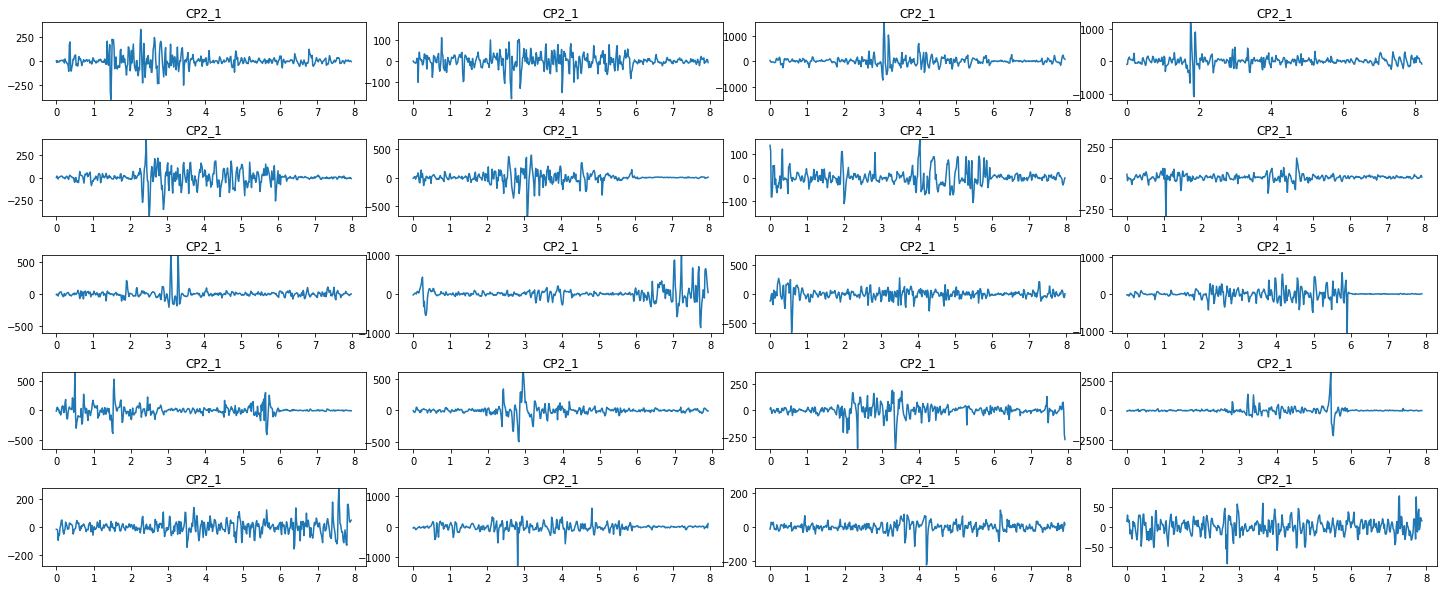

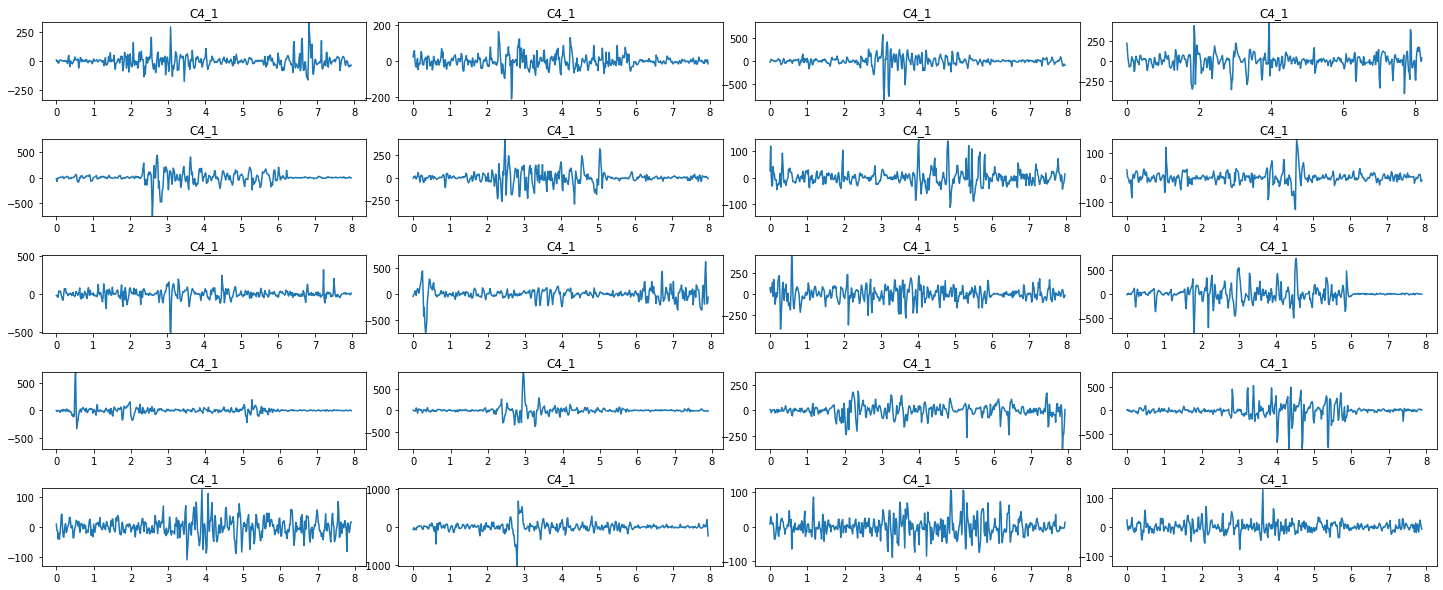

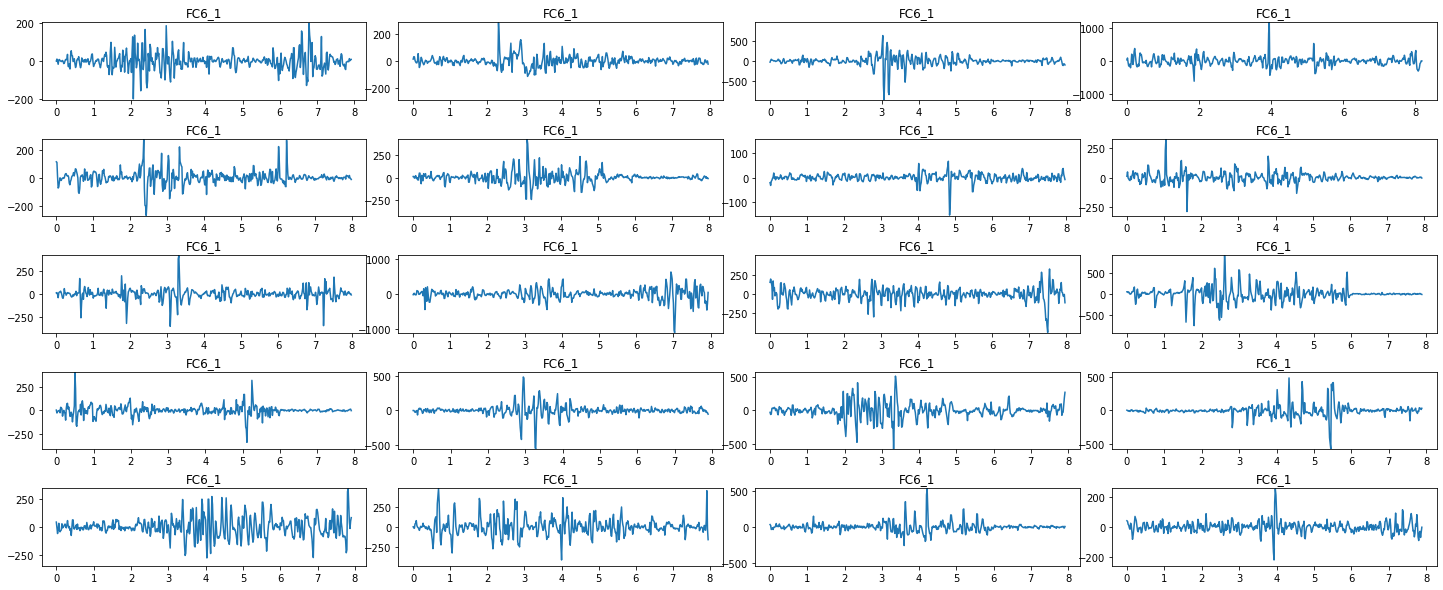

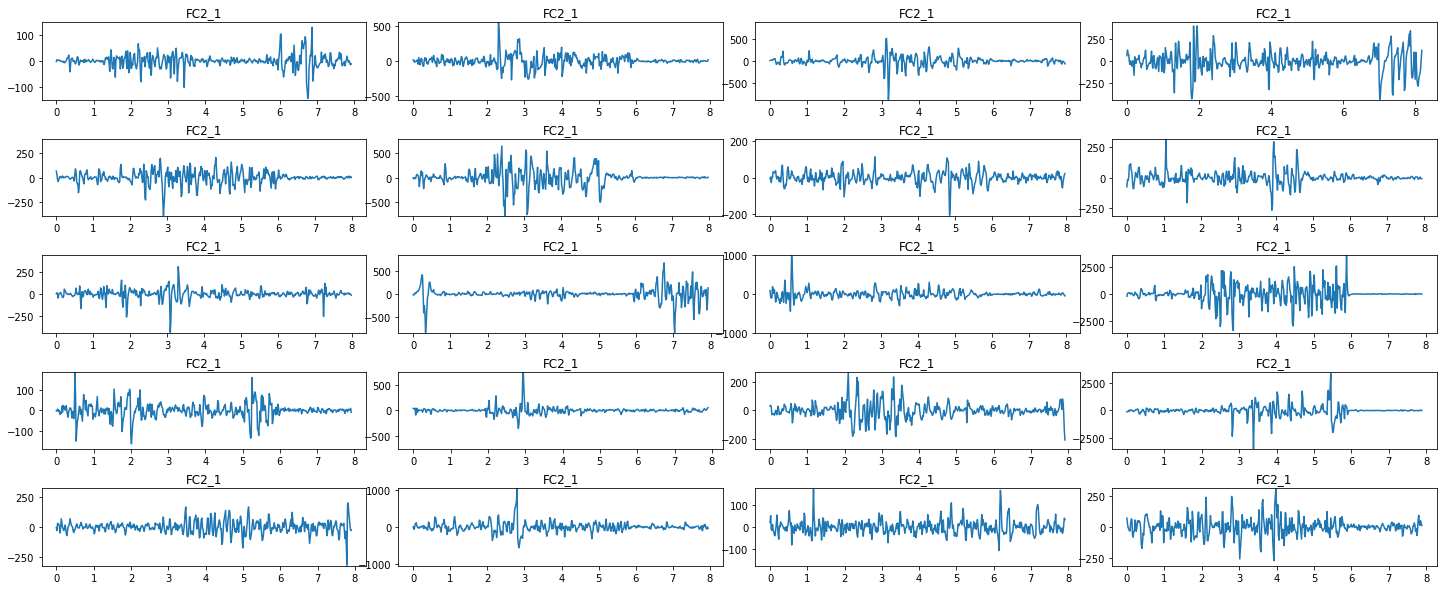

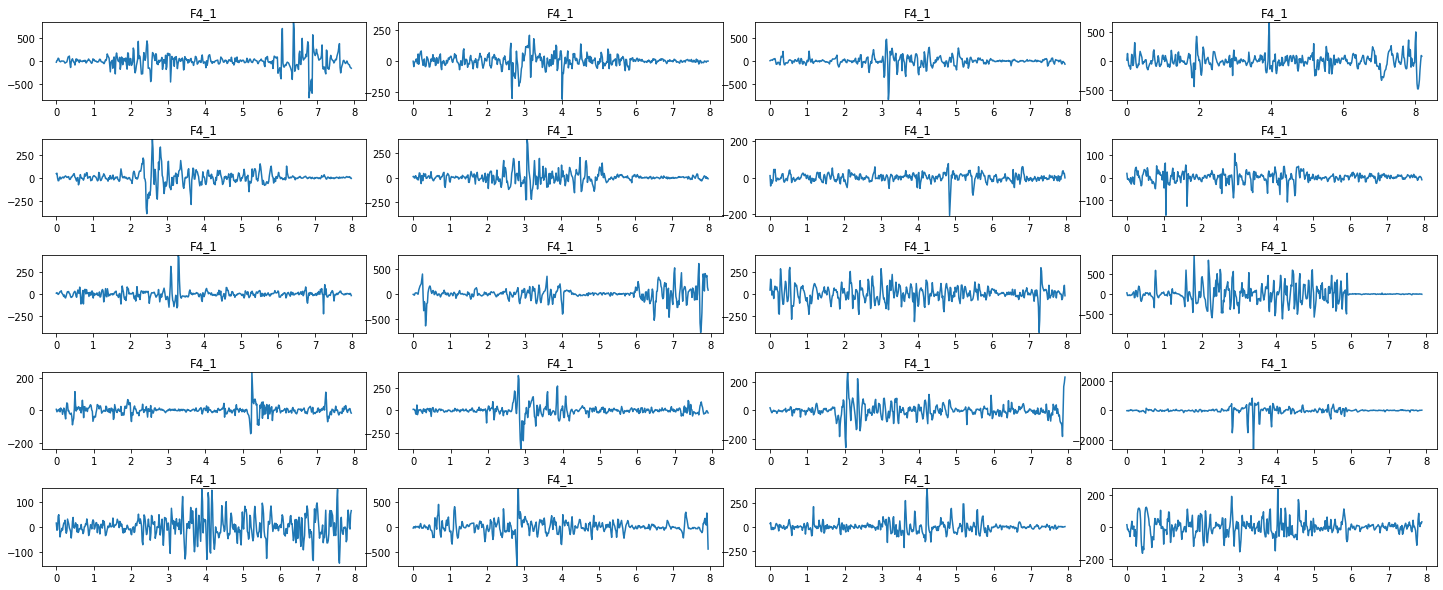

In [30]:
for j in range(len(bdatac[0][0][0])):
    fig=plt.figure(figsize=(25,10))
    num_rows = len(bdatac)//4+(len(bdatac)%4>0)
    for i in range(len(bdatac)):
        plt.subplot(num_rows,4,i+1)
        xlabel=np.arange(len(bdatac[i][0][:,j]))/60
        plt.plot(xlabel,bdatac[i][0][:,j])
        if np.abs(np.min(bdatac[i][0][:,j]))>=np.max(bdatac[i][0][:,j]):
            plt.ylim(np.min(bdatac[i][0][:,j])-5,np.abs(np.min(bdatac[i][0][:,j]))+5)
        else:
            plt.ylim(-np.max(bdatac[i][0][:,j])-5,np.max(bdatac[i][0][:,j])+5)
        plt.title(headfpc[0][j])
    plt.subplots_adjust(wspace=0.1,hspace=0.5)
    plt.show()
    #namesave=r'E:\KyotoUdata\EEG\rawc'+'\\'+headfpc[0][j]
    #fig.savefig(namesave,bbox_inches='tight', pad_inches=0,dpi=300)